In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import torch
import librosa
import torchaudio.transforms as T
import os
from IPython.display import Audio, display

plt.style.use(['science', 'notebook', 'grid'])

In [13]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c + 1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)


def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c + 1}')
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)


def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

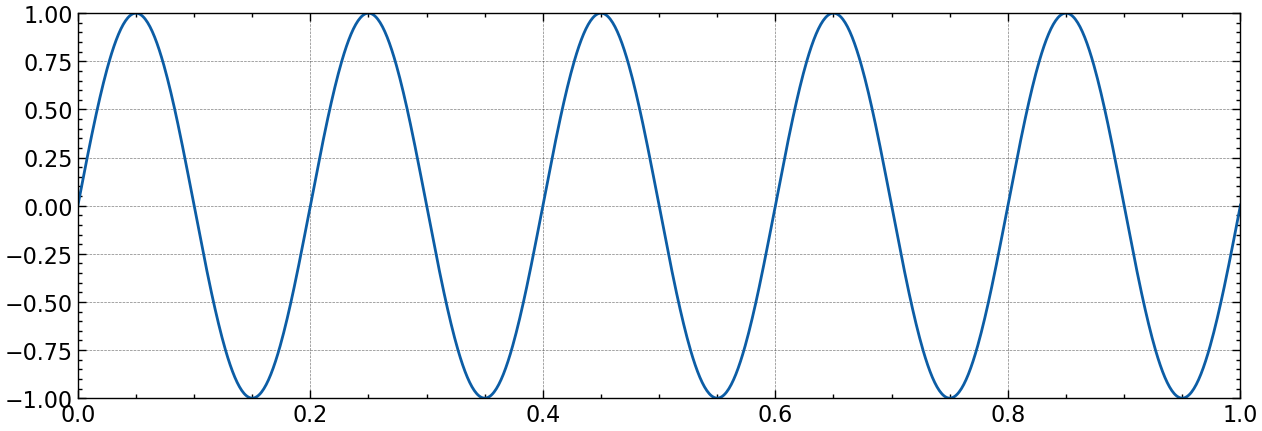

In [14]:
from scipy.io.wavfile import write


def fwaveform(amplitude, frequency, phase, xlim=(0, 1), samplerate=10000):
    t = np.linspace(*xlim, samplerate)
    return t, amplitude * np.sin(2 * np.pi * frequency * t + phase)


t, data = fwaveform(amplitude=1, frequency=5, phase=0, xlim=(0, 10), samplerate=10000)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(t, data)
ax.set_xlim([0, 1])
ax.set_ylim([-1, 1])
plt.show()

scaled = np.int16(data / np.max(np.abs(data)) * np.iinfo(np.int16).max)
write('sin_sim.wav', len(data), scaled)

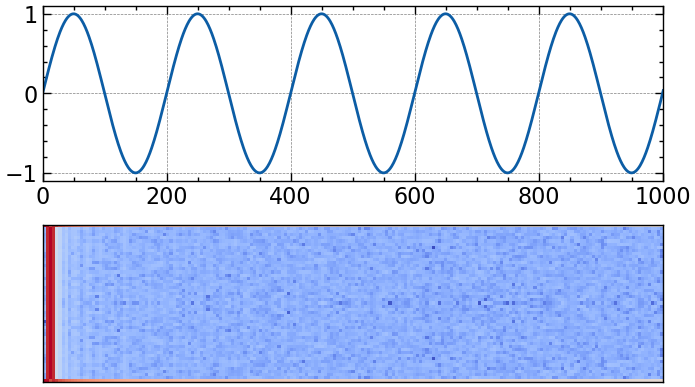

In [15]:
import torchaudio

filename = "sin_sim.wav"
waveform, sample_rate = torchaudio.load(filename)

fig, axes = plt.subplots(2, 1, figsize=(8, 5))

ax = axes[0]
ax.plot(waveform.t().numpy(), )
ax.set_xlim([0, 1000])

ax = axes[1]
specgram = torchaudio.transforms.Spectrogram()(waveform)
ax.imshow(np.transpose(specgram.log2()[0, :, :].numpy()), cmap='coolwarm')
ax.set_xticks([])
ax.set_yticks([])

plt.show()

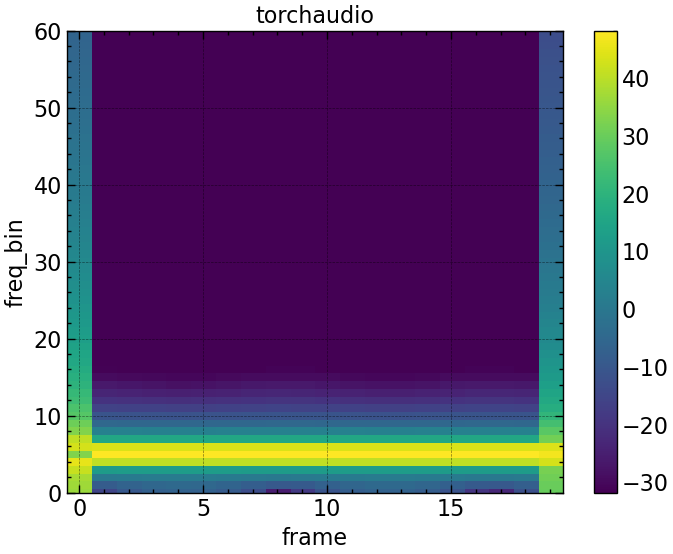

In [20]:
# define transformation
n_fft = 1024
win_length = None
hop_length = 512
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))

    axs.set_ylim([0,60])
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


filename = "sin_sim.wav"
waveform, sample_rate = torchaudio.load(filename)

spec = spectrogram(waveform)
plot_spectrogram(spec[0], title='torchaudio')

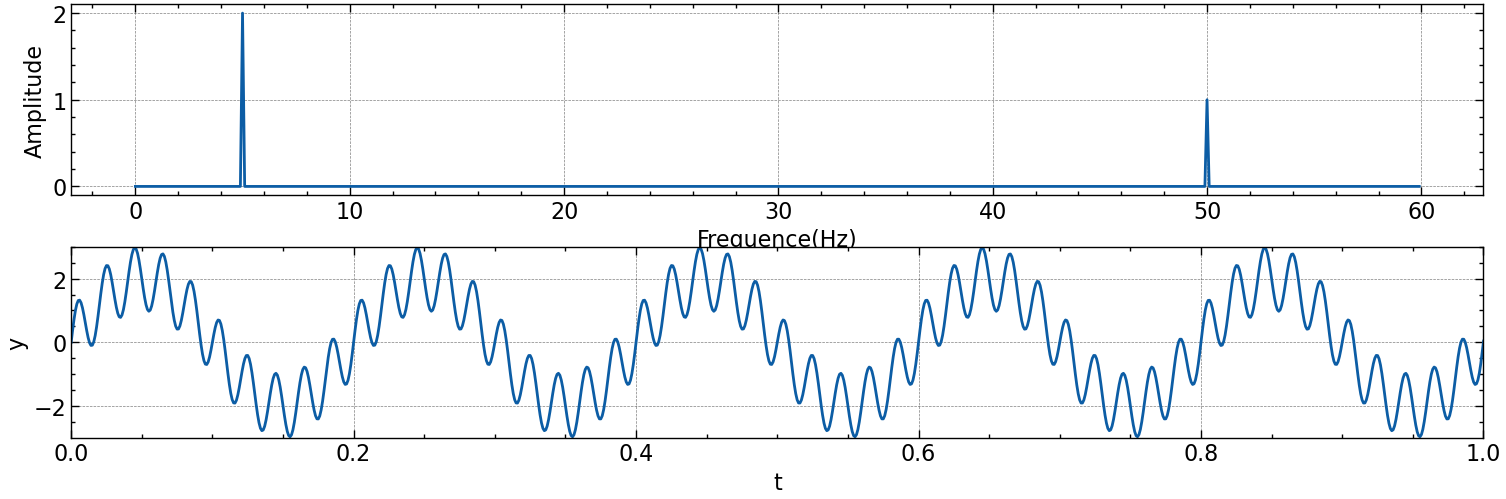

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
plt.tight_layout()

ax = axes[0]
f = np.arange(0, 60, 0.1)


def a(f):
    if f == 5:
        return 2
    elif f == 50:
        return 1
    else:
        return 0


ax.plot(f, [a(fi) for fi in f])
ax.set_xlabel("Frequence(Hz)")
ax.set_ylabel("Amplitude")

ax = axes[1]
t, wf1 = fwaveform(amplitude=2, frequency=5, phase=0, xlim=(0, 10))
t, wf2 = fwaveform(amplitude=1, frequency=50, phase=0, xlim=(0, 10))

data = wf1 + wf2
scaled = np.int16(data / np.max(np.abs(data)) * np.iinfo(np.int16).max)
write('sin_plx.wav', len(data), scaled)

ax.plot(t, data)
ax.set_xlabel("t")
ax.set_ylabel("y")
ax.set_xlim([0, 1])
ax.set_ylim([-3, 3])
plt.show()

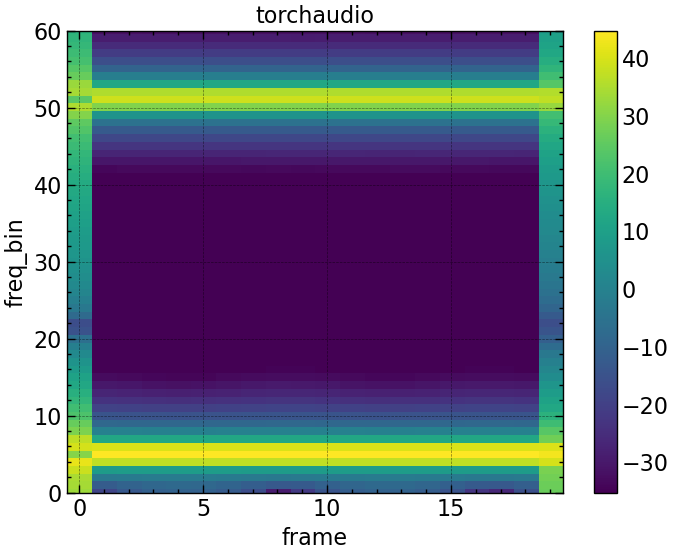

In [21]:
filename = "sin_plx.wav"
waveform, sample_rate = torchaudio.load(filename)
spec = spectrogram(waveform)
plot_spectrogram(spec[0], title='torchaudio')